In [20]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split

class PokemonPalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

pokemon_dir = './Qiita/ポケモン/poke_vs_digi/data/poke_old/'
pal_dir = 'data/every-pal-in-palworld-a-complete-paldeck-list/'

pokemon_images = [os.path.join(pokemon_dir, file) for file in os.listdir(pokemon_dir)]
pal_images = [os.path.join(pal_dir, file) for file in os.listdir(pal_dir)]
total_images = pokemon_images + pal_images
labels = [0] * len(pokemon_images) + [1] * len(pal_images)

# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(total_images, labels, test_size=0.2, random_state=42)

train_dataset = PokemonPalDataset(train_images, train_labels, transform=transform)
test_dataset = PokemonPalDataset(test_images, test_labels, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Total images: 613
Number of Pokemon images: 504
Number of Pal images: 109
Train dataset size: 490
Test dataset size: 123


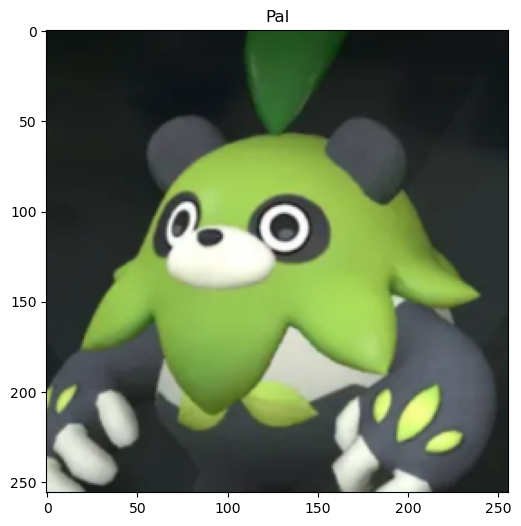

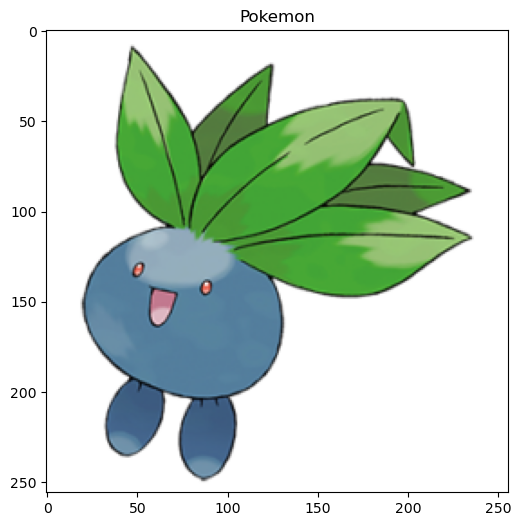

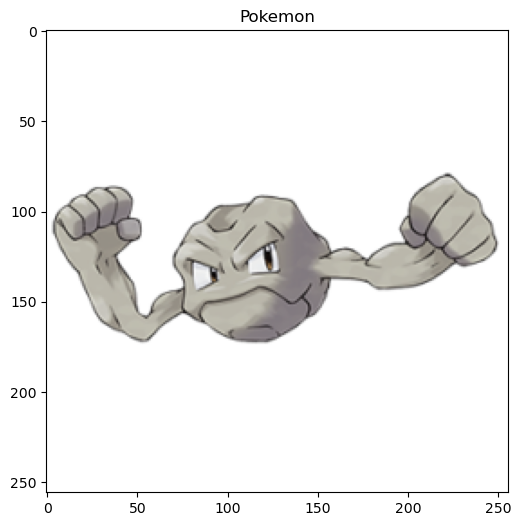

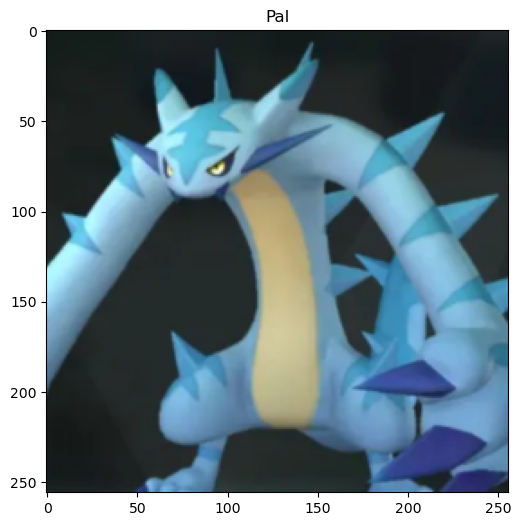

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data Summary
print(f"Total images: {len(total_images)}")
print(f"Number of Pokemon images: {len(pokemon_images)}")
print(f"Number of Pal images: {len(pal_images)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Show a transformed image sample from the dataset
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get a batch of training data
sample_images, sample_labels = next(iter(train_dataloader))

# Initialize counters for Pokemon and Pal images
pokemon_count, pal_count = 0, 0

# Show images
for i in range(len(sample_labels)):
    if sample_labels[i] == 0 and pokemon_count < 2:
        title = 'Pokemon'
        imshow(sample_images[i], title=title)
        pokemon_count += 1
    elif sample_labels[i] == 1 and pal_count < 2:
        title = 'Pal'
        imshow(sample_images[i], title=title)
        pal_count += 1
    if pokemon_count == 2 and pal_count == 2:
        break



In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128 * 64 * 64, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Output: [batch_size, 64, 128, 128]
        x = self.pool(self.relu(self.conv2(x)))  # Output: [batch_size, 128, 64, 64]
        x = x.view(-1, 128 * 64 * 64)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [27]:
# Training code

def train(model, optimizer, criterion, train_loader, test_loader, num_epochs, device):
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_test_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
        
        print(f"Epoch {epoch+1}: Train Loss = {running_loss/len(train_loader)}, Test Loss = {running_test_loss/len(test_loader)}")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Fixing the batch size mismatch error
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs=1, device=device)


Epoch 1: Train Loss = 6.853095764982666, Test Loss = 0.37893813848495483
Epoch 2: Train Loss = 0.13188380455219129, Test Loss = 0.00023310505699214445
